In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import zepid
from zepid.graphics import EffectMeasurePlot
import networkx as nx
from numpy import genfromtxt
from scipy import stats
import os
from IPython.display import Image

In [20]:
# Reseteo del directorio principal
os.getcwd()
os.chdir("C:\\Users\dadam\Review_EDA_Emotion_Recognition")

In [21]:
#Creación de data frames a usar
df_metadata = pd.read_csv('.\data\Tabla Normalizada - Metadata.csv')
df_data_type = pd.read_csv('.\data\Tabla Normalizada - Data type.csv')
df_participants = pd.read_csv('.\data\Tabla Normalizada - Participants.csv')
df_self_report = pd.read_csv('.\data\Tabla Normalizada - Self report.csv')
df_emotion_elicitation_techniques = pd.read_csv('.\data\Tabla Normalizada - Emotion elicitation techniques.csv')
df_eda = pd.read_csv('.\data\Tabla Normalizada - EDA.csv')
df_statistical_learning_models = pd.read_csv('.\data\Tabla Normalizada - Statistical Learning model.csv')
df_performances = pd.read_csv('.\data\Tabla Normalizada - Performances.csv')
df_alg_perf = pd.read_csv('.\data\Tabla Normalizada - Alg_Perf.csv')

In [5]:
#matplotlib.style.use(matplotlib.get_data_path()+'/stylelib/apa.mplstyle')

In [6]:
def multi_reversing(df,col_id, col_values):
    """la funcion toma nos da la frecuencia de los datos distribuidos en distintas columnas.
    Toma una variable distribuida en varias columnas (one hot encoding), y aplica la funcion melt para cambiar el formato
    de la tabla a long. Luego devuelve una columna donde aparece el nombre de cada columna, la cantidad de veces que fue
    marcada con una 'x' (si accuracy fue marcada 50 veces, aparecera el str 'accuracy' 50 veces, lo que permite graficar su frecuencia
    de aparicion)

    Args:
        df (dataframe): dataframe con el que se desea trabajar, debe poseer las columnas de id_vars y list_value_vars
        in_id_vars (str): nombre de la columna que se usa como identificador de variables 
        value_vars (str o lista): str o lista con el nombre de las columnas de las cuales se desea obtener los datos (se puede
        obviamente subsetear (p.e. dataframe.iloc['columna_1',...,columna_n']))

    Returns:
        dataframe: _description_
    """
    df_raw = pd.melt(df, id_vars = col_id, value_vars = col_values)
    return df_raw[df_raw.value == 'x']

def multi_reversing_n(df,col_id, col_values):
    """exactamente lo mismo que multi_reversing, solo que para casos donde lo que se busca es un numero y no una x
    """
    df_raw = pd.melt(df, id_vars = col_id, value_vars = col_values)
    return df_raw[df_raw.value != 0]

def bar_plot(col, data, titulos):
    var_x = col
    df = data
    g = sns.countplot(x=var_x, data=df, order = getattr(df, var_x).value_counts().index)
    g.set(title = titulos[0], xlabel = titulos[1], ylabel = titulos[2])
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.savefig(f'.\\Emmanuel\\figures\\NUEVOS. {titulos[0]}.jpg', dpi=1000)
    plt.show()

def t_student(x,y):
	print('Students t-test')
	from scipy.stats import ttest_ind
	stat, p = ttest_ind(x, y, alternative = 'greater')
	print('stat=%.3f, p=%.3f' % (stat, p))
	if p > 0.05:
		print('Probably the same distribution')
	else:
		print('Probably different distributions')


def mann_whitney_u(x,y):
	print('Mann-Whitney U Test')
	from scipy.stats import mannwhitneyu
	stat, p = mannwhitneyu(x, y, alternative = 'greater')
	print('stat=%.3f, p=%.3f' % (stat, p))
	if p > 0.05:
		print('Probably the same distribution')
	else:
		print('Probably different distributions')

def relaciones(weight):
    df_weights_dim = pd.DataFrame(weight)
    wserie = df_weights_dim.value_counts()
    wserie = wserie.to_frame()
    wserie.index.names = ['index']
    wserie.rename(columns = {0:'relations'}, inplace = True)
    wserie = wserie.reset_index()
    
    col1 = wserie.columns[0]
    col2 = wserie.columns[1]

    # iterar sobre las filas del dataframe
    for i, row in wserie.iterrows():
        print(f"Interacciones con {row[col1]} conexiones se observaron {row[col2]/2} veces.")

### ¿Los modelos de clasificacion dimensionales basados en arousal performan mejor que los basados en valence?

Análisis estadístico 
1. Subsetear par quedarse solo con modelso de “HV,LV” (y “LV, “HV”), y “HA,LA” (y “LA, “HA”).
2. FIltrar para quedarnos unicamente con papers que tengan tanto valencia Y arousal (al querer hacer modelos “intrasujeto” es imporatne que se cumpla con esta condición.
3. Agrupar  por paper y sacar la media de la performance (para que quede paper un unico valor de performance promedio de valencia, y un unico valor de performance promedio de arousal. Esto es fundamental para los pasos que siguen)
4. Recien ahora (y  no antes, esto es mucho muy importante) analizar cual es la medida de performance mas prevalente y subsetear para quedarnos solo con esa medida.
5. Hacer T test INTRASUJETO

In [7]:
#creacion data frame y subseteo por: modelos dimensionales, tipo clasiffier, categorias HA/LA y HV/LV
df_alg_perf = df_alg_perf.fillna(0)
df = df_alg_perf
df = df[df['affective_model'] == 'dimensional']
df = df[df['is_classifier'].isin(['x', 'X'])]
df = df[df['class_model_output_categories'].isin(['HA, LA', 'HV, LV', 'LA, HA', 'LV, HV'])]
df[['class_model_output_categories']] = df[['class_model_output_categories']].replace(['LA, HA', 'LV, HV'], ['HA, LA', 'HV, LV' ])

In [8]:
df[["paper_id", "apa_citation", "class_model_output_categories"]]

,paper_id,apa_citation,class_model_output_categories
2,3.0,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HA, LA"
3,3.0,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HV, LV"
44,11.0,"Girardi, D., Lanubile, F., & Novielli, N. (201...","HA, LA"
45,11.0,"Girardi, D., Lanubile, F., & Novielli, N. (201...","HV, LV"
129,20.0,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...","HA, LA"
...,...,...,...
492,97.0,"Ganapathy, N., & Swaminathan, R. (2019). Emoti...","HV, LV"
493,98.0,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HV, LV"
494,98.0,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HV, LV"
495,98.0,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HA, LA"


In [ ]:
2. FIltrar para quedarnos unicamente con papers que tengan tanto valencia Y arousal (al querer hacer modelos “intrasujeto” es imporatne que se cumpla con esta condición.

In [9]:
"""revision a mano de los modelos
vuela el paper_id 24, 37, 66, 97
porque no contenian modelos tanto para arousal como para valencia
se procede a filtrarlos"""

df.drop(df[ df['paper_id'] == 24].index,inplace = True)
df.drop(df[ df['paper_id'] == 37].index,inplace = True)
df.drop(df[ df['paper_id'] == 66].index,inplace = True)
df.drop(df[ df['paper_id'] == 97].index,inplace = True)
df_excel = df
df_excel.to_excel(".\data\\analisis_estadistico.xlsx")
df.iloc[:,57:]

,accuracy,precision,f-measure,recall-sensitivity-true_positive_rate,specificity_true-negative-rate,false-positive-rate,false-negative-rate,roc-auc,R2,R,MAE-(Mean-Absolute-Error),Concordance-Correlation-Coefficient-(CCC),Spearman’s-ranking-correlation,Mean-square-error-(MSE),Root-Mean-Square-Error-(RMSE),Pearson-Correlation Coefficient-(r),unweighted-average-recall-(UAR),Matthews-Correlation-Coefficient,G-mean-(Geometric-mean)
2,71.53,-,-,-,-,-,0,-,-,0,-,0,0,0,0,0,0,0,0.0
3,71.04,-,-,-,-,0,0,-,-,0,-,0,0,0,0,0,0,0,0.0
44,-,67,63,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
45,-,58,35,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
129,62.23,-,-,-,-,-,-,-,-,-,-,-,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,79,78.38,77.85,77.33,77.78,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
493,0,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
494,0,0,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
495,0,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [10]:
df[["paper_id", "model_id", "apa_citation", "class_model_output_categories"]]

,paper_id,model_id,apa_citation,class_model_output_categories
2,3.0,3.0,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HA, LA"
3,3.0,4.0,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HV, LV"
44,11.0,45.0,"Girardi, D., Lanubile, F., & Novielli, N. (201...","HA, LA"
45,11.0,46.0,"Girardi, D., Lanubile, F., & Novielli, N. (201...","HV, LV"
129,20.0,130.0,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...","HA, LA"
...,...,...,...,...
490,96.0,491.0,"Kołodziej, M., Tarnowski, P., Majkowski, A., &...","HA, LA"
493,98.0,494.0,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HV, LV"
494,98.0,495.0,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HV, LV"
495,98.0,496.0,"Subramanian, R., Wache, J., Abadi, M. K., Vier...","HA, LA"


In [11]:
"""
se calcula a mano los promedios de arousal y valencia para cada paper
"""
df2 = pd.read_excel(".\data\\Libro12.xlsx") 
df2.head()

,paper_id,apa_citation,year,affective_model,class_model_output_categories,accuracy,precision,f0measure,recall0sensitivity0true_positive_rate,specificity_true0negative0rate,...,R,MAE0(Mean0Absolute0Error),Concordance0Correlation0Coefficient0(CCC),Spearman’s0ranking0correlation,Mean0square0error0(MSE),Root0Mean0Square0Error0(RMSE),Pearson0Correlation Coefficient0(r),unweighted0average0recall0(UAR),Matthews0Correlation0Coefficient,G0mean0(Geometric0mean)
0,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...",2018,dimensional,"HA, LA",71.53,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...",2018,dimensional,"HV, LV",71.04,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,11,"Girardi, D., Lanubile, F., & Novielli, N. (201...",2018,dimensional,"HA, LA",0.00,67.0,63.0,64.0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,11,"Girardi, D., Lanubile, F., & Novielli, N. (201...",2018,dimensional,"HV, LV",0.00,58.0,35.0,50.0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,20,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...",2017,dimensional,"HA, LA",62.23,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


4. Recien ahora (y  no antes, esto es mucho muy importante) analizar cual es la medida de performance mas prevalente y subsetear para quedarnos solo con esa medida.

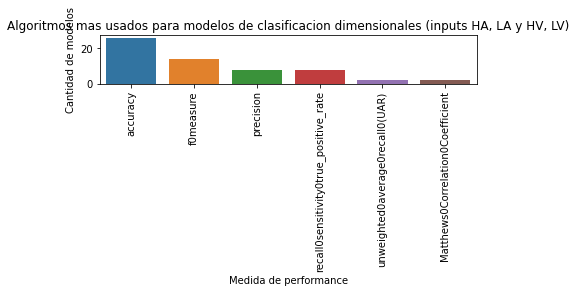

In [12]:
df_performance_medidas = multi_reversing_n(df2, 'paper_id',df2.iloc[:,5:])
titulos = ['Algoritmos mas usados para modelos de clasificacion dimensionales (inputs HA, LA y HV, LV)', 'Medida de performance', 'Cantidad de modelos']
bar_plot('variable',df_performance_medidas,titulos)

In [13]:
#filtramos por accuracy
df2 = df2.fillna('-')
df2 = df2[(df2['accuracy'] != '-') & (df2['accuracy'] != 0)]
df2[["paper_id", "apa_citation", "class_model_output_categories", "accuracy"]]

,paper_id,apa_citation,class_model_output_categories,accuracy
0,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HA, LA",71.53
1,3,"Ayata, D., Yaslan, Y., & Kamasak, M. E. (2018)...","HV, LV",71.04
4,20,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...","HA, LA",62.23
5,20,"Wiem, M. B. H., & Lachiri, Z. (2017). Emotion ...","HV, LV",55.78
6,23,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...","HA, LA",71.53
7,23,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...","HV, LV",71.04
10,32,"Siddharth, null, Jung, T.-P., & Sejnowski, T....","HA, LA",64.84
11,32,"Siddharth, null, Jung, T.-P., & Sejnowski, T....","HV, LV",63.28
12,38,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...","HA, LA",50.54
13,38,"Ayata, D., Yaslan, Y., & Kamasak, M. (2017). E...","HV, LV",65.33


In [14]:
#creamos df para el analisis estadistico
df_3 = df2[["class_model_output_categories","accuracy"]]
df_3

,class_model_output_categories,accuracy
0,"HA, LA",71.53
1,"HV, LV",71.04
4,"HA, LA",62.23
5,"HV, LV",55.78
6,"HA, LA",71.53
7,"HV, LV",71.04
10,"HA, LA",64.84
11,"HV, LV",63.28
12,"HA, LA",50.54
13,"HV, LV",65.33


Aplicamos los estadísticos

obtenido de: https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

OPCION 1 (EMMA)

In [15]:
#creacion lista con la performance para arousal y valence
df_arousal = df_3[df_3['class_model_output_categories'] == 'HA, LA']
df_arousal = df_arousal['accuracy']
arousal1 = df_arousal.values.tolist()
arousal1 = list(map(float, arousal1))

df_valence = df_3[df_3['class_model_output_categories'] == 'HV, LV']
df_valence = df_valence['accuracy']
valence1 = df_valence.values.tolist()
valence1 = list(map(float, valence1))

p1 = stats.ttest_rel(arousal1, valence1, alternative = "greater")

print(p1)

#Test parametrico - t de student
#t_student(arousal1, valence1)

#Test no parametrico - U de Mann-Whitney
#mann_whitney_u(arousal1, valence1)

Ttest_relResult(statistic=0.35229084656919984, pvalue=0.3653649152631109)


OPCION 2 (TOMI)

In [16]:
#creacion lista con la performance para arousal y valence
df_arousal = df_3[df_3['class_model_output_categories'] == 'HA, LA']
df_arousal = df_arousal['accuracy']
arousal1 = df_arousal.values.tolist()
arousal1 = list(map(float, arousal1))

df_valence = df_3[df_3['class_model_output_categories'] == 'HV, LV']
df_valence = df_valence['accuracy']
valence1 = df_valence.values.tolist()
valence1 = list(map(float, valence1))

#print(arousal1, valence1)

#Test parametrico - t de student
t_student(arousal1, valence1)

#Test no parametrico - U de Mann-Whitney
mann_whitney_u(arousal1, valence1)


Students t-test
stat=0.229, p=0.410
Probably the same distribution
Mann-Whitney U Test
stat=91.000, p=0.379
Probably the same distribution


In [17]:
print(arousal1)
print(valence1)
print(len(arousal1))
print(len(valence1))

[71.53, 62.23, 71.53, 64.84, 50.54, 79.0, 62.11, 64.33, 69.0, 72.08, 59.88, 57.24, 65.63]
[71.04, 55.78, 71.04, 63.28, 65.33, 69.8, 53.68, 71.2, 67.0, 68.9, 60.13, 55.92, 68.75]
13
13


In [18]:
arousal1bis =  [i for i in arousal1 if i != 0]
valence1bis =  [i for i in valence1 if i != 0]
print(arousal1bis)
print(valence1bis)



[71.53, 62.23, 71.53, 64.84, 50.54, 79.0, 62.11, 64.33, 69.0, 72.08, 59.88, 57.24, 65.63]
[71.04, 55.78, 71.04, 63.28, 65.33, 69.8, 53.68, 71.2, 67.0, 68.9, 60.13, 55.92, 68.75]


In [19]:
#Test parametrico - t de student
t_student(arousal1bis, valence1bis)

#Test no parametrico - U de Mann-Whitney
mann_whitney_u(arousal1bis, valence1bis)

Students t-test
stat=0.229, p=0.410
Probably the same distribution
Mann-Whitney U Test
stat=91.000, p=0.379
Probably the same distribution
